numba
===

The [numba](https://numba.pydata.org/) package offers an alternate way to speed up your python code by simply adding decorators ([example1](https://pythonbasics.org/decorators/), [example2](https://realpython.com/primer-on-python-decorators/)) to your functions.  

The code below uses:
* [numba](https://numba.pydata.org/)
  * [interactive demo notebooks](https://mybinder.org/v2/gh/numba/numba-examples/master?filepath=notebooks)
* [ctypes](https://docs.python.org/3/library/ctypes.html)
* [numpy](https://numpy.org/)
* [Pillow](https://pypi.org/project/Pillow/)

This directory contains a Python module numbalib.py which is virtual the same as mypylib, except that the functions are wrapped using numba to compile the Python code.  Look over the code before you begin.

In [ ]:
import numbalib
import mypylib
import numpy as np

Estimating pi using uniform random numbers
-----

We'll first measure the time of Python code with our findPi function.  We use 100M random numbers thrown in a unit square to estimate the value of pi.

In [ ]:
%time PI=mypylib.findPi(100*1000*1000)
print("Estimate for pi:",PI)

Now compare using the version with numba.

In [ ]:
%time PI=numbalib.findPi(100*1000*1000)
print("Estimate for pi:",PI)

Example 2: Visualizing the Mandelbrot Set
---

We'll begin with a pure python example to draw the [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set).

The Python interface is:

def mandel(img, re1, re2, im1, im2, nr, ni, NTRIALS=255)<br>
* img = image array[npX][npY]
* re1, re2 = range to explore on real axis
* im1, im2 = range to explore in imaginary axis
* nr, ni = number of divisions in re/im ranges
* NTRIALS = numebr of iterrations to easimate if a point is included in the set

In [ ]:
import numpy as np
# define parameters for the calulation
npX=2000   # 2000 x 2000 pixel image
npY=2000
nTrials=255
re1=-2.1
re2=0.6
im1=-1.5
im2=1.5
img=np.ndarray(shape=(npX,npY), dtype=np.double) # array to hold our image

In [ ]:
%time mypylib.mandel(img,re1,re2,im1,im2,npX,npY,nTrials) # this will take a moment....

Next, let's make a nice picture.  I'll leave it as an optional exercise if you want to add color.

In [ ]:
from PIL import Image

# convert values to 0 - 255 int8 format
img=np.log(img)
img = (img/img.max()*255).astype('uint8')
image = Image.fromarray(img)

display(image)

Now repeat using the library with numba

In [ ]:
%time numbalib.mandel(img,re1,re2,im1,im2,npX,npY,nTrials) # this will be fast....

Homework project
=================

Project 1
---------
Examine the Python code below.  And create a version using numba jit compilation.  Then produce a plot showing the ratio of the time required to perform the calculation in the two cases (Python/Python+numba) versus the input number *n*.  Extend your plot to at least n=2500.

In [1]:
def count3d(n):
    count=0
    for i in range (n):
        for j in range (i+1,n):
            for k in range (j+1,n):
                count = count +1
    return count

In [2]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

@njit(cache=True)
def count3d_numba(n: int) -> int:
    cnt = 0
    for i in range(n):
        for j in range(i + 1, n):
            cnt += (n - (j + 1))
    return cnt

_ = count3d_numba(10)


Below we use the [timeit module](https://docs.python.org/3/library/timeit.html) instead of the cell magick %time.  This allow us to retrieve the time in a Python variable.
Note: computer timers have limited accuracy, therefore you may observe large fractional fluctuations for small times.  The estimate can be improved by averaging over several calls to the code.  Be aware of this, but you don't need to be very accurate in measuring the small times for this project, the case for large *n* is the most interesting region!

In the example below timeit executes the count3d function with n=10.  In this examples the calculation is repeated number=1 times in a trial.  By default 5 trials are run and the best time is reported.  See the timeit documentation for more information.

In [3]:
#%time count3d(ncount)

ncount=10
import timeit
execTime=timeit.timeit(f'count3d({ncount})', number=1, globals=globals())
print(f'execution time = {execTime} seconds')

execution time = 9.901999874273315e-06 seconds


In [4]:
def best_time(stmt, glb, number=1, repeat=5):
    t = timeit.Timer(stmt, globals=glb)
    return min(t.repeat(repeat=repeat, number=number)) / number

ns = [200, 400, 800, 1200, 1600, 2000, 2500]  

py_times, nb_times, ratios = [], [], []

for n in ns:
    t_py = best_time(f'count3d({n})', globals(), number=1, repeat=3)
    py_times.append(t_py)

    t_nb = best_time(f'count3d_numba({n})', globals(), number=1, repeat=3)
    nb_times.append(t_nb)

    r = t_py / t_nb
    ratios.append(r)

    print(f"n={n:5d} | python={t_py:.6f}s  numba={t_nb:.6f}s  ratio={r:.2f}", flush=True)


n=  200 | python=0.032944s  numba=0.000001s  ratio=47883.42
n=  400 | python=0.325663s  numba=0.000001s  ratio=341723.70
n=  800 | python=2.633781s  numba=0.000002s  ratio=1708028.15
n= 1200 | python=8.816948s  numba=0.000002s  ratio=4068730.57
n= 1600 | python=21.103668s  numba=0.000003s  ratio=7679641.06
n= 2000 | python=42.659806s  numba=0.000003s  ratio=12532263.30
n= 2500 | python=89.179121s  numba=0.000004s  ratio=21846910.96


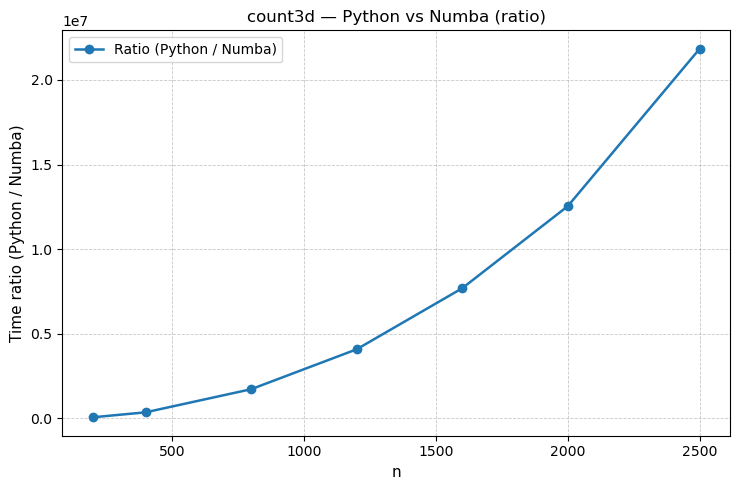

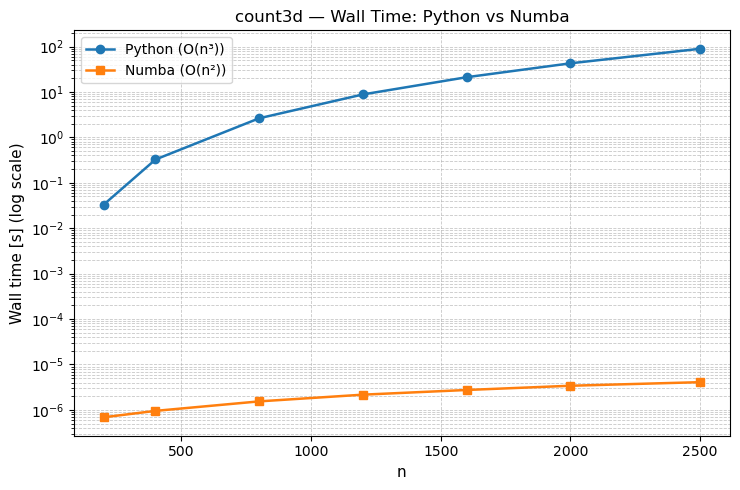

In [9]:
plt.figure(figsize=(7.5, 5.0))
plt.plot(ns, ratios, marker='o', linewidth=1.8, label='Ratio (Python / Numba)')
plt.xlabel('n', fontsize=11)
plt.ylabel('Time ratio (Python / Numba)', fontsize=11)
plt.title('count3d — Python vs Numba (ratio)', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
plt.legend(frameon=True, loc='best')
plt.tight_layout()
plt.savefig('ratio_python_numba.png', dpi=200, bbox_inches='tight')
plt.show()
plt.close()

# Plot below is for the comparison between actual time instead of ratio.
plt.figure(figsize=(7.5, 5.0))
plt.plot(ns, py_times, marker='o', linewidth=1.8, label='Python (O(n³))')
plt.plot(ns, nb_times, marker='s', linewidth=1.8, label='Numba (O(n²))')
plt.yscale('log')
plt.xlabel('n', fontsize=11)
plt.ylabel('Wall time [s] (log scale)', fontsize=11)
plt.title('count3d — Wall Time: Python vs Numba', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)
plt.legend(frameon=True, loc='best')
plt.tight_layout()
plt.savefig('time_python_vs_numba.png', dpi=200, bbox_inches='tight')
plt.show()
plt.close()

